# Weather Prediction Model Training
**Dataset:** Weather Dataset
**Target:** Weather (Multi-class Classification: rain, sun, fog, drizzle, snow)
**Models:** Random Forest, Gradient Boosting, XGBoost, Neural Network


## Part 1: Imports and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Set paths
# Notebook is in: ar-navigation-system/backend/ml_models/notebooks/
# Dataset is in: ar-navigation-system/backend/dataset/
# Models will be in: ar-navigation-system/backend/models/

NOTEBOOK_DIR = Path().resolve()  # Current notebook directory
BACKEND_DIR = NOTEBOOK_DIR.parent.parent  # Go up to backend directory
DATA_PATH = BACKEND_DIR / "dataset" / "weather.csv"
MODEL_DIR = BACKEND_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR = MODEL_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Backend directory: {BACKEND_DIR}")
print(f"Data path: {DATA_PATH}")
print(f"Data file exists: {DATA_PATH.exists()}")
print(f"Model directory: {MODEL_DIR}")
print(f"Plots directory: {PLOTS_DIR}")


Notebook directory: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\ml_models\notebooks
Backend directory: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend
Data path: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\dataset\weather.csv
Data file exists: True
Model directory: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models
Plots directory: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models\plots


## Part 2: Data Loading


In [2]:
# Load dataset
df = pd.read_csv(DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (1461, 6)

Columns: ['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather']

First few rows:


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


## Part 3: Data Exploration and EDA


In [3]:
# Basic information
print("Dataset Info:")
print("=" * 60)
df.info()
print("\n" + "=" * 60)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "=" * 60)
print("\nDataset Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


Missing Values:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64


Dataset Statistics:
       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%     

Target Variable Distribution:
weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64

Number of classes: 5


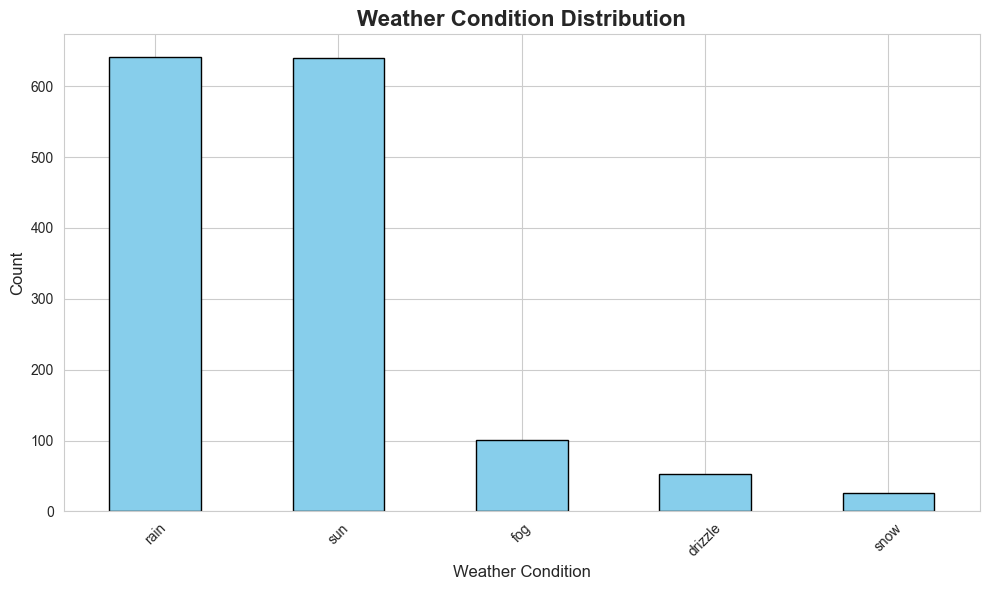

In [4]:
# Check target distribution
print("Target Variable Distribution:")
print("=" * 60)
weather_counts = df['weather'].value_counts()
print(weather_counts)
print(f"\nNumber of classes: {df['weather'].nunique()}")

# Visualize target distribution
plt.figure(figsize=(10, 6))
weather_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Weather Condition Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


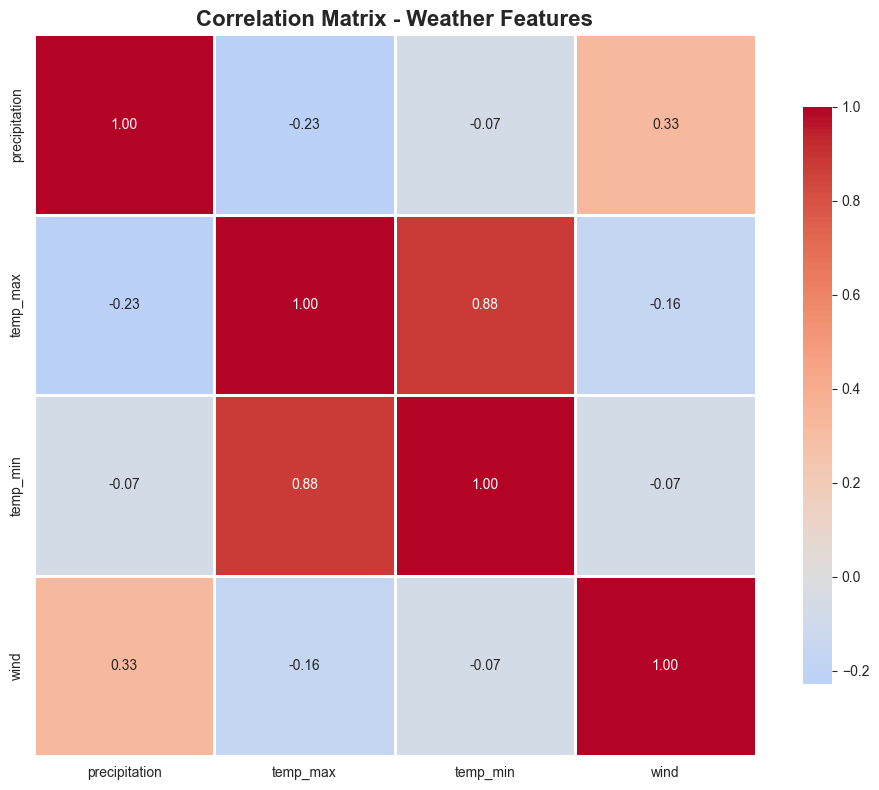

In [5]:
# Correlation matrix
numeric_cols = ['precipitation', 'temp_max', 'temp_min', 'wind']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Weather Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1400x800 with 0 Axes>

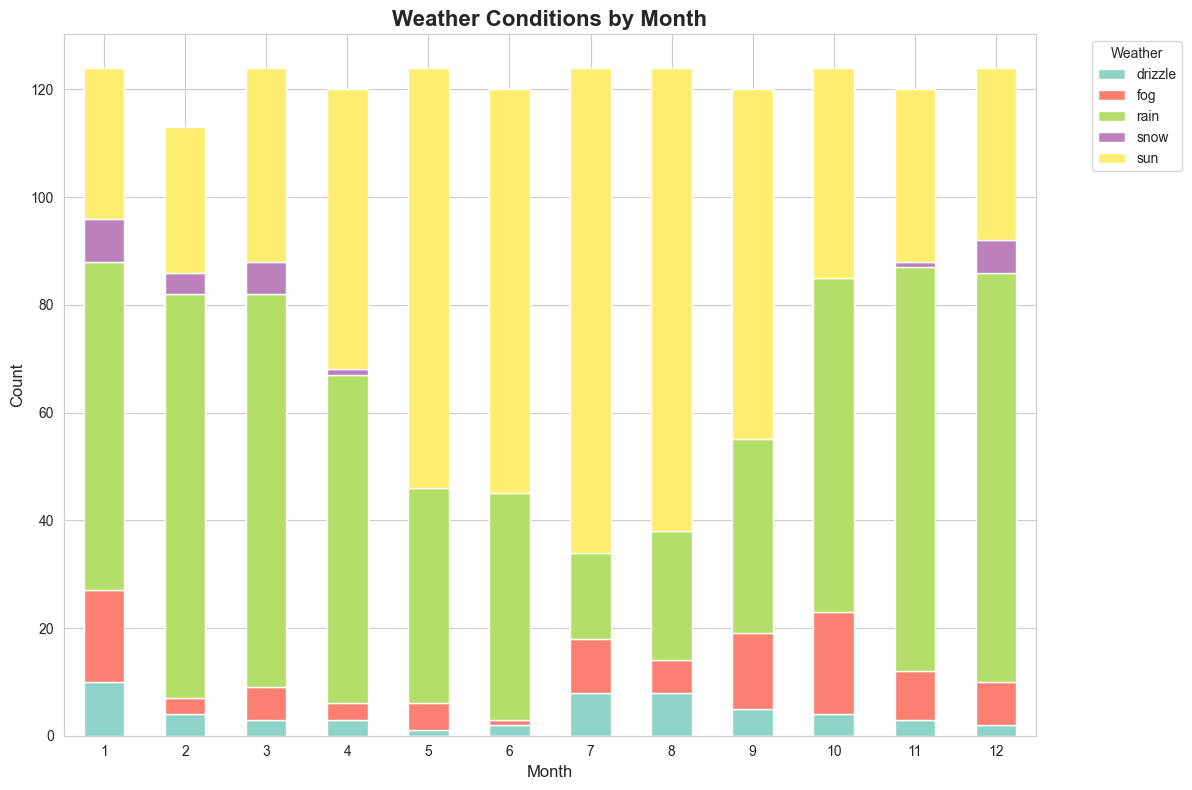

In [6]:
# Weather by month analysis
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

month_weather = pd.crosstab(df['month'], df['weather'])

plt.figure(figsize=(14, 8))
month_weather.plot(kind='bar', stacked=True, colormap='Set3')
plt.title('Weather Conditions by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Weather', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'weather_by_month.png', dpi=300, bbox_inches='tight')
plt.show()


## Part 4: Data Preprocessing


In [7]:
# Create a copy for preprocessing
df_processed = df.copy()

# Separate features and target
target = df_processed['weather'].copy()

# Extract date features
df_processed['date'] = pd.to_datetime(df_processed['date'])
df_processed['year'] = df_processed['date'].dt.year
df_processed['month'] = df_processed['date'].dt.month
df_processed['day'] = df_processed['date'].dt.day
df_processed['day_of_year'] = df_processed['date'].dt.dayofyear
df_processed['day_of_week'] = df_processed['date'].dt.dayofweek
df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)

# Calculate average temperature
df_processed['temp_avg'] = (df_processed['temp_max'] + df_processed['temp_min']) / 2

# Calculate temperature range
df_processed['temp_range'] = df_processed['temp_max'] - df_processed['temp_min']

# Drop original date column
features_df = df_processed.drop(['weather', 'date'], axis=1, errors='ignore')

print(f"Features shape: {features_df.shape}")
print(f"Target shape: {target.shape}")
print(f"\nFeature columns: {list(features_df.columns)}")
print(f"\nTarget classes: {target.unique()}")


Features shape: (1461, 12)
Target shape: (1461,)

Feature columns: ['precipitation', 'temp_max', 'temp_min', 'wind', 'month', 'year', 'day', 'day_of_year', 'day_of_week', 'is_weekend', 'temp_avg', 'temp_range']

Target classes: ['drizzle' 'rain' 'sun' 'snow' 'fog']


In [8]:
# Encode target variable
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

print(f"Original target shape: {target.shape}")
print(f"Encoded target shape: {target_encoded.shape}")
print(f"\nLabel mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i}: {class_name}")


Original target shape: (1461,)
Encoded target shape: (1461,)

Label mapping:
  0: drizzle
  1: fog
  2: rain
  3: snow
  4: sun


In [9]:
# Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    features_df, target_encoded, test_size=0.15, random_state=42, stratify=target_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 = 0.15
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTotal features: {X_train.shape[1]}")


Training set: 1022 samples
Validation set: 219 samples
Test set: 220 samples

Total features: 12


In [10]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully")
print(f"Training set mean: {X_train_scaled.mean().mean():.4f}")
print(f"Training set std: {X_train_scaled.std().mean():.4f}")


Features scaled successfully
Training set mean: 0.0000
Training set std: 1.0005


## Part 5: Model Training


In [11]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss'),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

results = {}
trained_models = {}

print("Models initialized:")
for name in models.keys():
    print(f"  - {name}")


Models initialized:
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - Neural Network


In [12]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)
    
    # Use scaled data for Neural Network, original for tree-based models
    if name == 'Neural Network':
        X_train_model = X_train_scaled
        X_val_model = X_val_scaled
    else:
        X_train_model = X_train
        X_val_model = X_val
    
    # Train model
    model.fit(X_train_model, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_model)
    y_val_pred = model.predict(X_val_model)
    
    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(
        model, X_train_model, y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
        scoring='accuracy',
        n_jobs=-1
    )
    
    results[name] = {
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    trained_models[name] = model
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f}")
    print(f"Val Recall: {val_recall:.4f}")
    print(f"Val F1-Score: {val_f1:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Training Random Forest...
Train Accuracy: 1.0000
Val Accuracy: 0.8630
Val Precision: 0.8556
Val Recall: 0.8630
Val F1-Score: 0.8441
CV Accuracy: 0.8640 (+/- 0.0300)

Training Gradient Boosting...
Train Accuracy: 0.9853
Val Accuracy: 0.8356
Val Precision: 0.8265
Val Recall: 0.8356
Val F1-Score: 0.8172
CV Accuracy: 0.8444 (+/- 0.0137)

Training XGBoost...
Train Accuracy: 1.0000
Val Accuracy: 0.8539
Val Precision: 0.8495
Val Recall: 0.8539
Val F1-Score: 0.8370
CV Accuracy: 0.8474 (+/- 0.0458)

Training Neural Network...
Train Accuracy: 0.9687
Val Accuracy: 0.7763
Val Precision: 0.7587
Val Recall: 0.7763
Val F1-Score: 0.7572
CV Accuracy: 0.7828 (+/- 0.0242)


## Part 6: Model Comparison



Model Comparison:
                   train_accuracy  val_accuracy  val_precision  val_recall  \
Random Forest            1.000000      0.863014       0.855580    0.863014   
XGBoost                  1.000000      0.853881       0.849502    0.853881   
Gradient Boosting        0.985323      0.835616       0.826456    0.835616   
Neural Network           0.968689      0.776256       0.758700    0.776256   

                     val_f1   cv_mean    cv_std  
Random Forest      0.844062  0.864022  0.015009  
XGBoost            0.837010  0.847408  0.022894  
Gradient Boosting  0.817240  0.844438  0.006833  
Neural Network     0.757181  0.782807  0.012084  


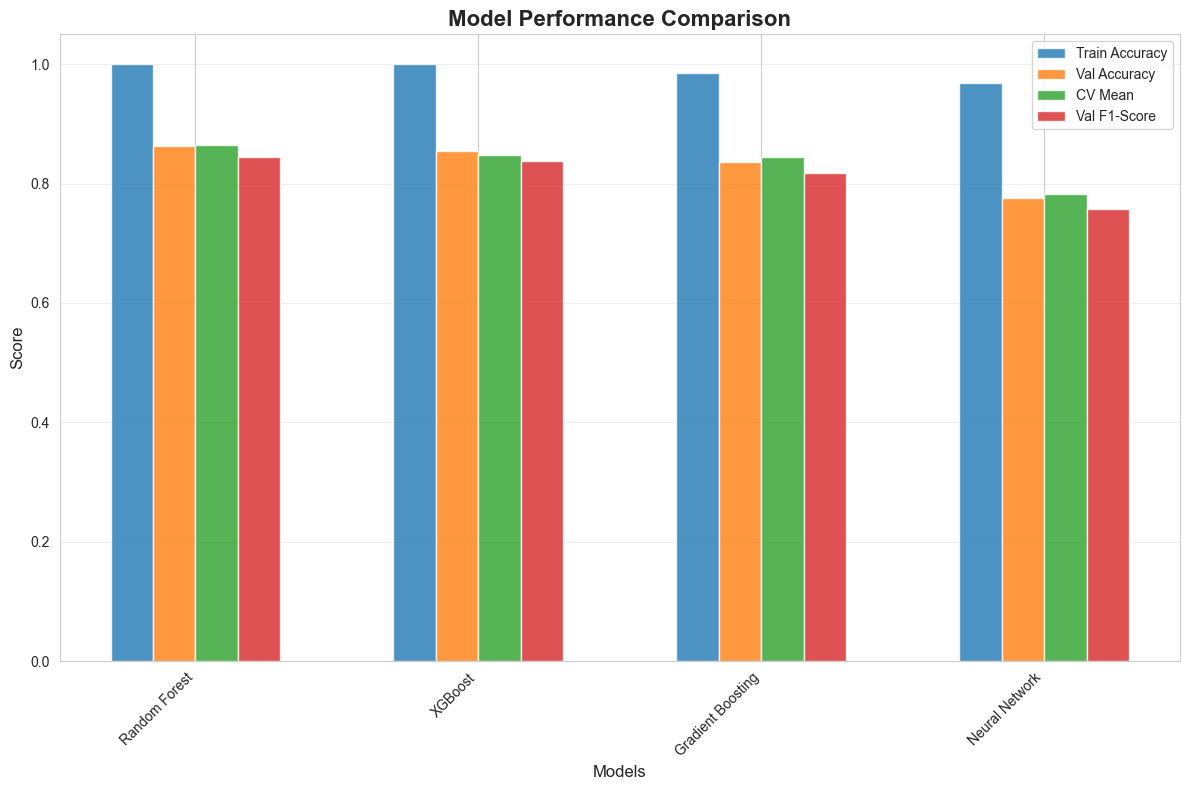


Best Model: Random Forest
Validation Accuracy: 0.8630


In [13]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('val_accuracy', ascending=False)

print("\n" + "="*60)
print("Model Comparison:")
print("="*60)
print(comparison_df)

# Visualize comparison
plt.figure(figsize=(12, 8))
x = np.arange(len(comparison_df))
width = 0.15

plt.bar(x - 1.5*width, comparison_df['train_accuracy'], width, label='Train Accuracy', alpha=0.8)
plt.bar(x - 0.5*width, comparison_df['val_accuracy'], width, label='Val Accuracy', alpha=0.8)
plt.bar(x + 0.5*width, comparison_df['cv_mean'], width, label='CV Mean', alpha=0.8)
plt.bar(x + 1.5*width, comparison_df['val_f1'], width, label='Val F1-Score', alpha=0.8)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xticks(x, comparison_df.index, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Select best model
best_model_name = comparison_df.index[0]
best_model = trained_models[best_model_name]

print(f"\n{'='*60}")
print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {comparison_df.loc[best_model_name, 'val_accuracy']:.4f}")
print("="*60)


## Part 7: Detailed Evaluation of Best Model


In [14]:
# Evaluate best model on test set
if best_model_name == 'Neural Network':
    X_test_model = X_test_scaled
else:
    X_test_model = X_test

y_test_pred = best_model.predict(X_test_model)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Set Performance:")
print("="*60)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("\n" + "="*60)
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Test Set Performance:
Accuracy: 0.8500
Precision: 0.8476
Recall: 0.8500
F1-Score: 0.8249


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.50      0.12      0.20         8
         fog       0.75      0.20      0.32        15
        rain       0.96      0.92      0.94        97
        snow       1.00      0.25      0.40         4
         sun       0.78      0.97      0.86        96

    accuracy                           0.85       220
   macro avg       0.80      0.49      0.54       220
weighted avg       0.85      0.85      0.82       220



<Figure size 1000x800 with 0 Axes>

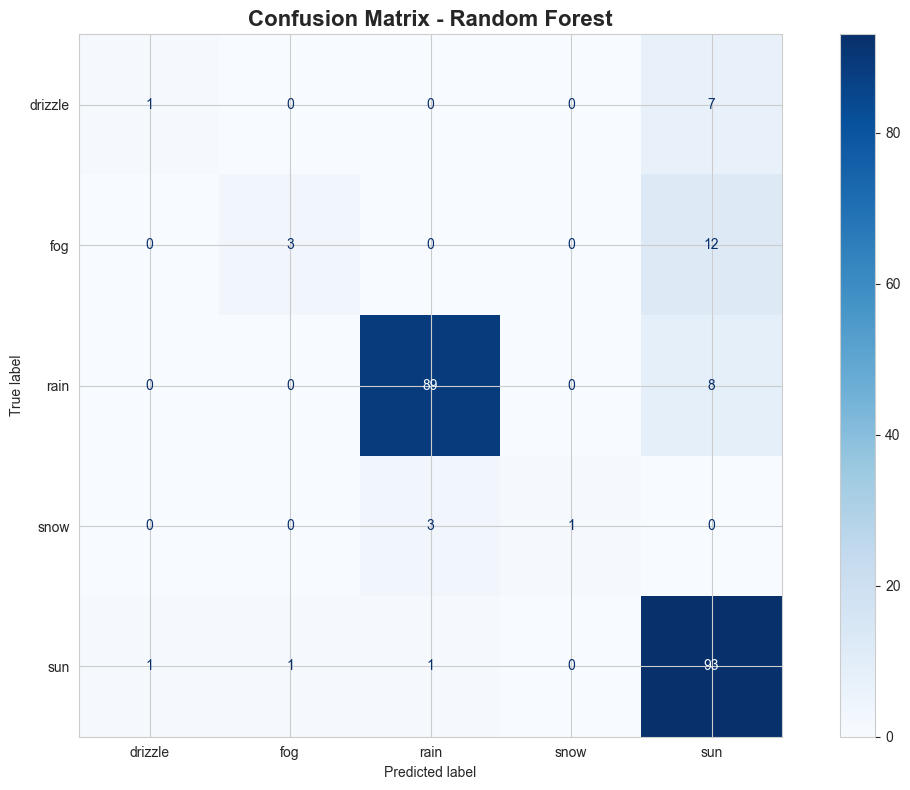

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


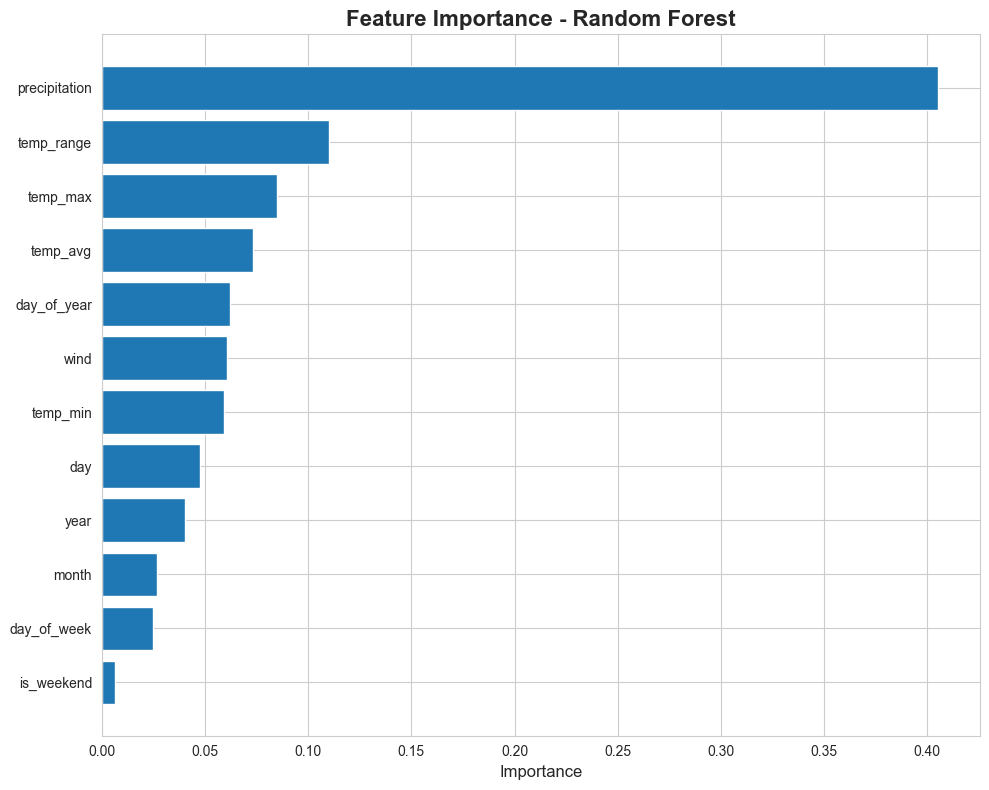


Top 10 Most Important Features:
          feature  importance
0   precipitation    0.405318
11     temp_range    0.110061
1        temp_max    0.084882
10       temp_avg    0.073115
7     day_of_year    0.061940
3            wind    0.060580
2        temp_min    0.058981
6             day    0.047337
5            year    0.040058
4           month    0.026554


In [16]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))


## Part 8: Save Model and Metadata


In [17]:
# Save model
model_path = MODEL_DIR / "weather_model.joblib"
joblib.dump(best_model, model_path)
print(f"[OK] Model saved to: {model_path}")

# Save scaler
scaler_path = MODEL_DIR / "weather_scaler.joblib"
joblib.dump(scaler, scaler_path)
print(f"[OK] Scaler saved to: {scaler_path}")

# Save label encoder
encoder_path = MODEL_DIR / "weather_label_encoder.joblib"
joblib.dump(label_encoder, encoder_path)
print(f"[OK] Label encoder saved to: {encoder_path}")

# Save feature columns
feature_columns = list(X_train.columns)
feature_columns_path = MODEL_DIR / "weather_feature_columns.joblib"
joblib.dump(feature_columns, feature_columns_path)
print(f"[OK] Feature columns saved to: {feature_columns_path}")


[OK] Model saved to: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models\weather_model.joblib
[OK] Scaler saved to: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models\weather_scaler.joblib
[OK] Label encoder saved to: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models\weather_label_encoder.joblib
[OK] Feature columns saved to: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models\weather_feature_columns.joblib


In [18]:
# Save comprehensive metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'train_accuracy': float(results[best_model_name]['train_accuracy']),
    'val_accuracy': float(results[best_model_name]['val_accuracy']),
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'cv_mean': float(results[best_model_name]['cv_mean']),
    'cv_std': float(results[best_model_name]['cv_std']),
    'num_features': len(feature_columns),
    'feature_columns': feature_columns,
    'label_classes': list(label_encoder.classes_),
    'target_variable': 'weather',
    'requires_scaling': best_model_name == 'Neural Network',
    'dataset': 'weather.csv',
    'dataset_size': len(df)
}

metadata_path = MODEL_DIR / "weather_model_metadata.joblib"
joblib.dump(metadata, metadata_path)
print(f"[OK] Metadata saved to: {metadata_path}")

print("\nMetadata Summary:")
for key, value in metadata.items():
    if key != 'feature_columns':  # Skip printing full feature list
        print(f"{key}: {value}")


[OK] Metadata saved to: D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models\weather_model_metadata.joblib

Metadata Summary:
model_name: Random Forest
model_type: RandomForestClassifier
train_accuracy: 1.0
val_accuracy: 0.863013698630137
test_accuracy: 0.85
test_precision: 0.8476270772238516
test_recall: 0.85
test_f1: 0.8248963317384371
cv_mean: 0.8640219990435198
cv_std: 0.015008706695296208
num_features: 12
label_classes: ['drizzle', 'fog', 'rain', 'snow', 'sun']
target_variable: weather
requires_scaling: False
dataset: weather.csv
dataset_size: 1461


## Part 9: Prediction Test


In [19]:
# Load saved model and components
model_path = MODEL_DIR / "weather_model.joblib"
scaler_path = MODEL_DIR / "weather_scaler.joblib"
encoder_path = MODEL_DIR / "weather_label_encoder.joblib"
metadata_path = MODEL_DIR / "weather_model_metadata.joblib"

loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_encoder = joblib.load(encoder_path)
loaded_metadata = joblib.load(metadata_path)

print("Model and components loaded successfully")
print(f"Model: {loaded_metadata['model_name']}")
print(f"Test Accuracy: {loaded_metadata['test_accuracy']:.4f}")


Model and components loaded successfully
Model: Random Forest
Test Accuracy: 0.8500


In [20]:
# Test prediction with sample data
sample_idx = 0
sample_data = X_test.iloc[[sample_idx]]

print("Sample Input Data:")
print("="*60)
print(sample_data.T)

# Make prediction
if loaded_metadata['requires_scaling']:
    sample_scaled = loaded_scaler.transform(sample_data)
    sample_scaled = pd.DataFrame(sample_scaled, columns=sample_data.columns, index=sample_data.index)
    prediction = loaded_model.predict(sample_scaled)
else:
    prediction = loaded_model.predict(sample_data)

predicted_class = loaded_encoder.inverse_transform(prediction)[0]
# y_test is a numpy array, so use array indexing instead of .iloc
actual_class = loaded_encoder.inverse_transform([y_test[sample_idx]])[0]

print("\n" + "="*60)
print("Prediction Result:")
print("="*60)
print(f"Predicted: {predicted_class}")
print(f"Actual: {actual_class}")
print(f"Match: {predicted_class == actual_class}")


Sample Input Data:
                  362
precipitation     0.0
temp_max          8.3
temp_min          3.9
wind              1.7
month            12.0
year           2012.0
day              28.0
day_of_year     363.0
day_of_week       4.0
is_weekend        0.0
temp_avg          6.1
temp_range        4.4

Prediction Result:
Predicted: sun
Actual: rain
Match: False


## Part 10: Summary


In [21]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nDataset: {len(df)} records")
print(f"Features: {len(feature_columns)}")
print(f"Target: Weather ({len(label_encoder.classes_)} classes)")
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n" + "="*60)
print("\nAll models, scaler, encoder, and metadata saved to:")
print(f"  {MODEL_DIR}")
print("\nAll plots saved to:")
print(f"  {PLOTS_DIR}")



TRAINING SUMMARY

Dataset: 1461 records
Features: 12
Target: Weather (5 classes)

Best Model: Random Forest
Test Accuracy: 0.8500 (85.00%)


All models, scaler, encoder, and metadata saved to:
  D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models

All plots saved to:
  D:\Education and Works\Dreamware projects\Ambulance-Emergency\ar-navigation-system\backend\models\plots
